In [1]:
#@title Imports and Constants
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

_NUM_SAMPLES = 10000
_RANDOM_SEED = 42

# Split Train/Test/Val (60/20/20)
_NUM_TRAIN_SAMPLES = int(0.6 * _NUM_SAMPLES)
_NUM_TEST_SAMPLES = int(0.2 * _NUM_SAMPLES)
_NUM_VAL_SAMPLES = _NUM_SAMPLES - (_NUM_TRAIN_SAMPLES + _NUM_TEST_SAMPLES)

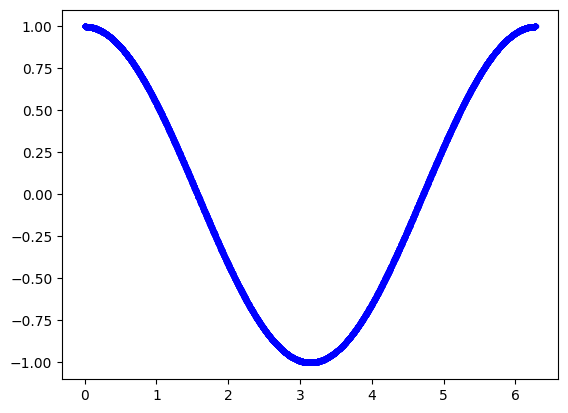

In [2]:
#@title Generate Cosine Data
# Set random seed for both TF and Numpy to allow for reproducability.
np.random.seed(_RANDOM_SEED)
tf.random.set_seed(_RANDOM_SEED)

# Generate random distribution of x values in range 0-2pi.
x_vals = np.random.uniform(low=0, high=2*math.pi, size=_NUM_SAMPLES)
np.random.shuffle(x_vals)
y_vals = np.cos(x_vals)

# 'b.' tells library to print blue dots.
plt.plot(x_vals, y_vals, 'b.')
plt.show()

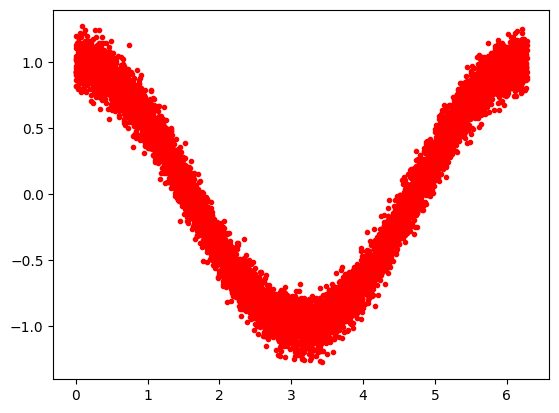

In [3]:
#@title Noise-ify Cosine Data

noised_y_vals = y_vals
noised_y_vals += 0.1 * np.random.randn(*y_vals.shape)
plt.plot(x_vals, noised_y_vals, 'r.')
plt.show()

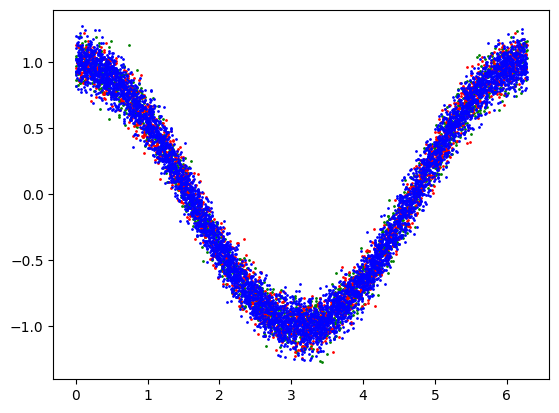

In [4]:
#@title Splitting the dataset

# There's better ways to do this with numpy.
x_train = x_vals[:_NUM_TRAIN_SAMPLES]
x_test = x_vals[_NUM_TRAIN_SAMPLES:_NUM_TRAIN_SAMPLES + _NUM_TEST_SAMPLES]
x_validation = x_vals[_NUM_TRAIN_SAMPLES + _NUM_TEST_SAMPLES:]

y_train = noised_y_vals[:_NUM_TRAIN_SAMPLES]
y_test = noised_y_vals[_NUM_TRAIN_SAMPLES:_NUM_TRAIN_SAMPLES + _NUM_TEST_SAMPLES]
y_validation = noised_y_vals[_NUM_TRAIN_SAMPLES + _NUM_TEST_SAMPLES:]

assert x_train.size + x_validation.size + x_test.size == _NUM_SAMPLES

plt.plot(x_test, y_test, 'og', label='Test', markersize=1)
plt.plot(x_validation, y_validation, 'or', label='Val', markersize=1)
plt.plot(x_train, y_train, 'ob', label='Train', markersize=1)

plt.show()

In [5]:
#@title Define A Simple Model Architecture
model = tf.keras.Sequential([
  # First scalar layer uses ReLu units
  tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)),
  # Add a second dense layer of shape 16.
  tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)),
  # Final layer is a single neuron (one output)
  tf.keras.layers.Dense(1)
])

# Compile the model with a root-mean-square optimizer
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Get model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
#@title Training the model
train_history = model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data = (x_validation, y_validation))

Epoch 1/10
375/375 [==============================] - 12s 11ms/step - loss: 0.4730 - mae: 0.6173 - val_loss: 0.3964 - val_mae: 0.5614
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.2383 - mae: 0.4261 - val_loss: 0.0888 - val_mae: 0.2530
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.0314 - mae: 0.1377 - val_loss: 0.0137 - val_mae: 0.0933
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0136 - mae: 0.0919 - val_loss: 0.0211 - val_mae: 0.1140
Epoch 5/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0136 - mae: 0.0919 - val_loss: 0.0167 - val_mae: 0.1022
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0133 - mae: 0.0908 - val_loss: 0.0134 - val_mae: 0.0926
Epoch 7/10
375/375 [==============================] - 1s 4ms/step - loss: 0.0135 - mae: 0.0912 - val_loss: 0.0197 - val_mae: 0.1104
Epoch 8/10
375/375 [==============================] - 1s 4ms/step - loss: 

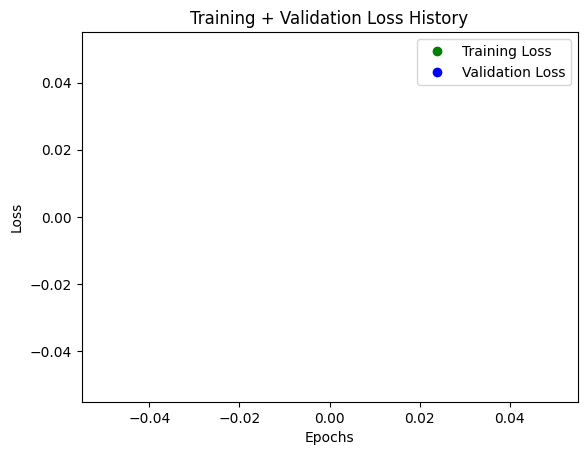

In [7]:
#@title Plot Training History

# Get specific loss history
loss = train_history.history['loss'][10:]
validation_loss = train_history.history['val_loss'][10:]
epochs = range(1, len(loss) + 1) # Create list of all individual epoch indices

plt.plot(epochs, loss, 'og', label='Training Loss')
plt.plot(epochs, validation_loss, 'ob', label='Validation Loss')
plt.title('Training + Validation Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

63/63 [==============================] - 0s 2ms/step


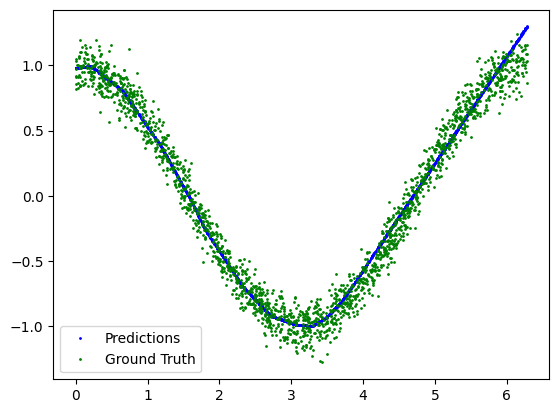

In [8]:
#@title Plot Test Data

y_pred = model.predict(x_test)

plt.clf()
plt.plot(x_test, y_pred, 'ob', label = 'Predictions', markersize=1)
plt.plot(x_test, y_test, 'og', label = 'Ground Truth', markersize=1)
plt.legend()
plt.show()

In [9]:
#@title Intro to TFLite

# Define TFLiteConverter object from 'model'.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimizations as field in TFLiteConverter
# DEFAULT includes quantization
converter.optimization = [tf.lite.Optimize.DEFAULT]

# Representative Dataset --> Shows model range of inputs to properly quantize
def generate_representative_dataset():
  for x_value in x_test:
      # Each scalar value must be in a 2D array wrapped in a list
      yield [np.array(x_value, dtype=np.float32, ndim=2)]

# Set representative dataset in converter.
converter.representative_dataset = generate_representative_dataset

# Convert model
tflite_model = converter.convert()

# Save model to disk
open('cosine_model_quantized.tflite', 'wb').write(tflite_model)

3164

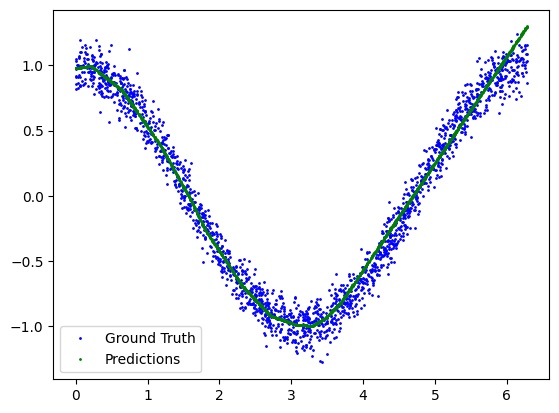

In [10]:
#@title Test Quantized Model

# Load model
cosine_model = tf.lite.Interpreter('cosine_model_quantized.tflite')

# Allocate memory for model
cosine_model.allocate_tensors()

# Get input and output tensors
cosine_model_input_index = cosine_model.get_input_details()[0]['index']
cosine_model_output_index = cosine_model.get_output_details()[0]['index']

# Run each models interpreter through test values
cosine_model_predictions = []
for x_value in x_test:
  # TF uses 2D tensors for everything, even scalars
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  # Write value to input tensor
  cosine_model.set_tensor(cosine_model_input_index, x_value_tensor)
  # Run inference
  cosine_model.invoke()
  # Read prediction and store in output array
  cosine_model_predictions.append(cosine_model.get_tensor(cosine_model_output_index)[0])

plt.clf()
plt.plot(x_test, y_test, 'ob', markersize=1, label='Ground Truth')
plt.plot(x_test, cosine_model_predictions, 'og', markersize=1, label='Predictions')
plt.legend()
plt.show()

In [11]:
#@title Convert to C File

# TFLite models can't be stored in the file system, many embedded systems don't
# have file systems, so we need to store the bytes as an array of data.

# XXD --> Unix Tool - Converts a given file into a format of bytes

# Install XXD
!apt-get -qq install xxd
# Apparently '-qq' makes the apt get noisy when you download something

# Save model to C source file
!xxd -i cosine_model_quantized.tflite > cosine_model_quantized.cc

# Print Source Output
!cat cosine_model_quantized.cc

unsigned char cosine_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x90, 0x00, 0x00, 0x00, 0xe8, 0x00, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00,
  0x10, 0x07, 0x00, 0x00, 0x08, 0x0c, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x98, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x32, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 